# Glioma Grading Clinical and Mutation Features

In [1]:
from pathlib import Path

import pandas as pd

from src.data_processing import convert_age, encode_dataset, normalize_dataset
from src.feature_estimators import get_feature_estimator, select_by_correlation_value, concat_important_features
from src.visualize import make_2d_representation

# Data processing
---

In [2]:
DATASETS_PATH = Path('datasets')
train_dataset_path = DATASETS_PATH / 'train.csv'
test_dataset_path = DATASETS_PATH / 'test.csv'

In [3]:
data = pd.read_csv(train_dataset_path, index_col=0)
data.head()

,Grade,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,GBM,TCGA-06-A6S0,Male,79 years 183 days,Glioblastoma,black or african american,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,TCGA-HT-8106,Male,53 years 197 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
2,LGG,TCGA-HT-7607,Female,61 years 305 days,"Astrocytoma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,TCGA-QH-A6X5,Female,58 years 55 days,Mixed glioma,white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
4,LGG,TCGA-P5-A5F1,Male,30 years 113 days,"Astrocytoma, NOS",white,MUTATED,MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


### Column Analysis

* The `Grade` column is our target.

* The column `Primary_Diagnosis` has 5 unique values, we will encode it with `LabelEncoder`.

* Column `Case_ID` represents unique id of case, we will remove from our dataset.

* The following columns represent the gen mutations.
    ```text
    IDH1, TP53, ATRX, PTEN, EGFR, CIC, MUC16, PIK3CA,
    NF1, PIK3R1, FUBP1, RB1, NOTCH1, BCOR, CSMD3, SMARCA4,
    GRIN2A, IDH2, FAT4, PDGFRA
    ```
    They might be only `MUTATED` or `NOT_MUTATED`, so we will encode it with `LabelEncoder`.

* The binary type column `Gender` will be encoded with `LabelEncoder` too.

* The `Age_at_diagnosis` column has a string representation of date. We will convert it into the numeric type.

### Missing Data

We detect that 4 cases has no `Age_at_diagnosis` data. We decided to remove them from training set.

In [4]:
data_processing = data.copy().drop(['Case_ID'], axis=1)


data_processing['Age_at_diagnosis'] = convert_age(data_processing['Age_at_diagnosis'])
data_processing = data_processing.dropna(axis=0)

object_columns = list(data_processing.select_dtypes(include='object').columns)
data_processing = encode_dataset(data_processing, columns=object_columns, verbose=False)

2d Representation of our data is presented at the figure below

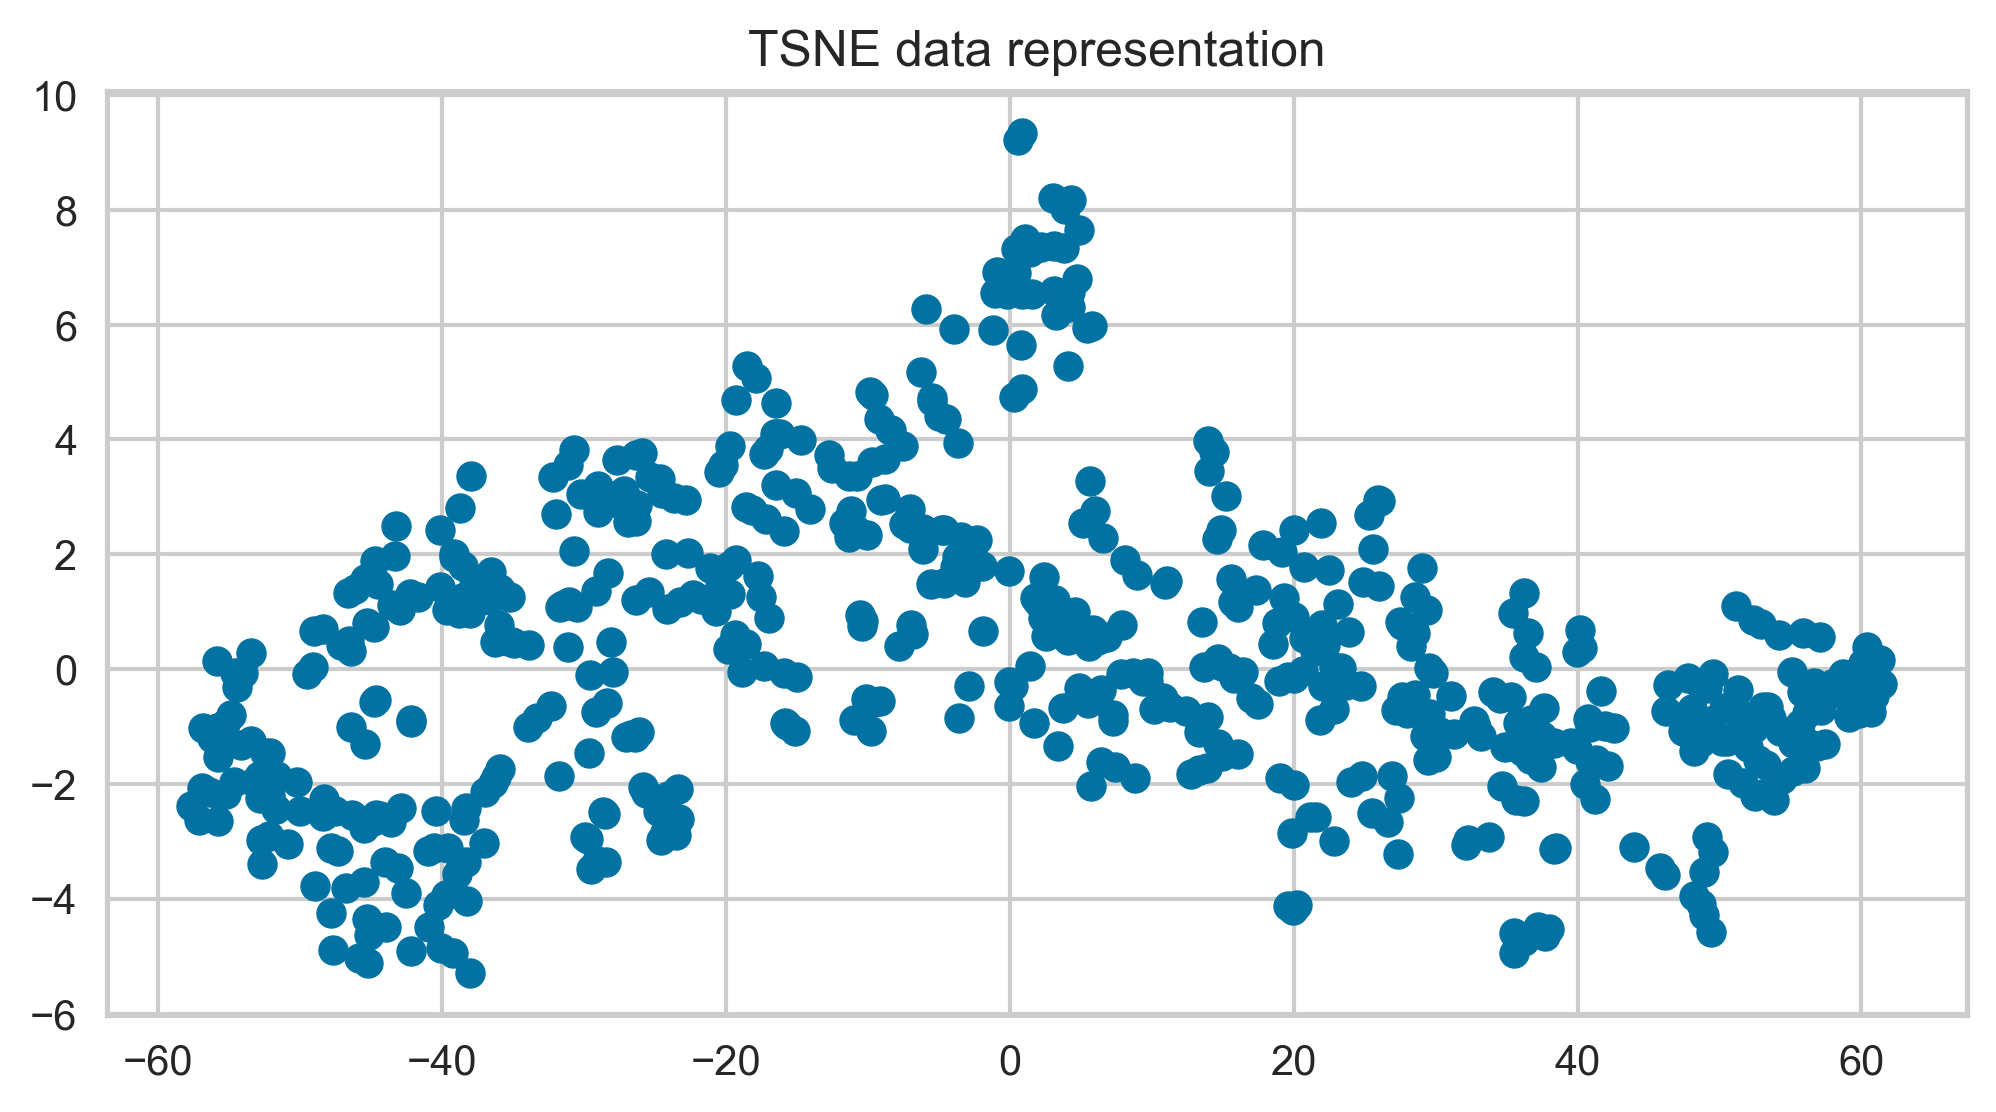

In [5]:
figure = make_2d_representation(data_processing)

## Feature selection
---

To investigate the most valuable features we decided to calculate some correlation metrics.

In [6]:
data_for_feature_analysis = data_processing.copy()
training_data = normalize_dataset(data_for_feature_analysis.drop(['Grade'], axis=1))
targets = data_for_feature_analysis['Grade']

### Mutual information
Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.


{'Primary_Diagnosis': 0.6813527550864881, 'IDH1': 0.2924145984915667}

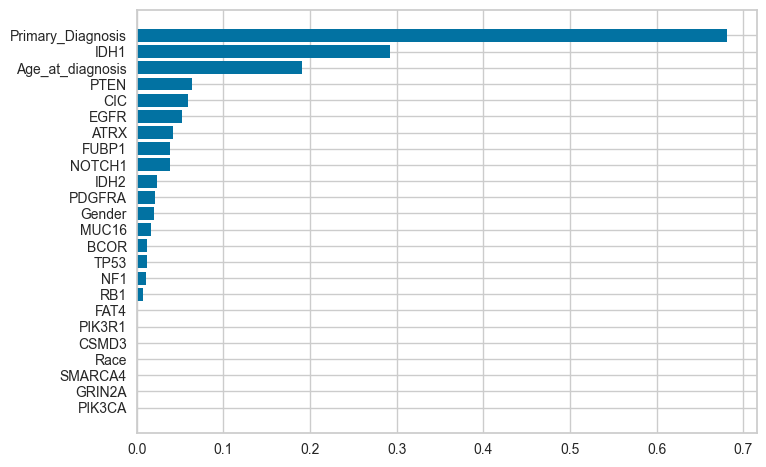

In [7]:
correlation_estimator = get_feature_estimator(training_data, targets, method='mutual_info-classification')
mutual_important_values = select_by_correlation_value(correlation_estimator, min_score=0.2)
mutual_important_values

The most valuable features are:
```text
Primary_Diagnosis, IDH1, Age_at_diagnosis
```

The least valuable features are:
```text
Gender, BCOR, FAT4, PIK3CA, Race, GRIN2A, PIK3R1
```

### Pearson's 

The Pearson correlation measures the strength of the linear relationship between two variables.

{'PTEN': 0.38394516594881184,
 'Primary_Diagnosis': 0.23253375516688293,
 'EGFR': 0.23206341419732243,
 'RB1': 0.22234650446066526,
 'CIC': -0.3047543785243079,
 'ATRX': -0.33949642354790255,
 'Age_at_diagnosis': -0.5287350927689329,
 'IDH1': -0.718406498813457}

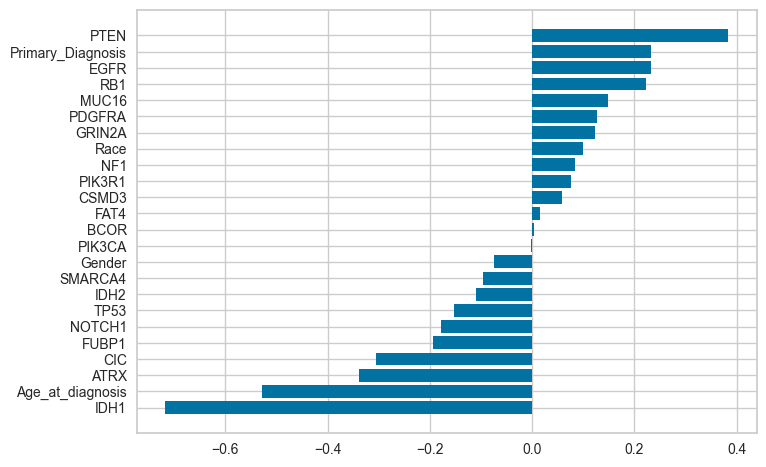

In [8]:
correlation_estimator = get_feature_estimator(training_data, targets, method='pearson')
pearson_important_values = select_by_correlation_value(correlation_estimator, min_score=0.2)
pearson_important_values

The most valuable features are
```text
IDH1, Age_at_diagnosis, PTEN, ATRX, CIC
```

The least valuable features are:
```text
BKOR, PIK3CA, FAT4
```

### Selected Features

We decided to automatically select features if their correlation metric is greater than 0.2

In [9]:
keep_columns = concat_important_features(pearson_important_values, mutual_important_values)
training_data = training_data[keep_columns]
training_data

,EGFR,Age_at_diagnosis,PTEN,RB1,IDH1,Primary_Diagnosis,ATRX,CIC
0,0.39261,1.806288,0.450346,0.217262,0.946345,-0.272867,0.565140,0.392610
1,0.39261,0.143589,0.450346,0.217262,-1.056697,-1.040224,0.565140,0.392610
2,0.39261,0.674895,0.450346,0.217262,-1.056697,-1.807581,0.565140,0.392610
3,0.39261,0.438896,0.450346,0.217262,-1.056697,0.494491,0.565140,-2.547057
4,0.39261,-1.344171,0.450346,0.217262,-1.056697,-1.807581,-1.769473,0.392610
...,...,...,...,...,...,...,...,...
597,0.39261,-1.298551,0.450346,0.217262,-1.056697,-1.807581,-1.769473,0.392610
599,0.39261,-1.501914,0.450346,0.217262,-1.056697,-1.040224,-1.769473,0.392610
600,0.39261,-1.422428,0.450346,0.217262,-1.056697,0.494491,-1.769473,0.392610
601,0.39261,0.035679,0.450346,0.217262,-1.056697,2.029206,0.565140,0.392610


## Experiments with model